# Set up a rectangular regional CESM-MOM6-CICE coupled run

We'll go through these steps:

1. Generate a regional MOM6 domain.
2. Create the CESM case.
3. Prepare ocean forcing data.
4. Generate the regional CICE grid.
5. Build and run the case.

Remember to swap your environment to CrocoDash first!

# Section 1: Generate a regional MOM6 domain

We begin by defining a regional MOM6 domain using CrocoDash. To do so, we first generate a horizontal grid. We then generate the topography by remapping an existing bathymetric dataset to our horizontal grid. Finally, we define a vertical grid.

## Step 1.1: Horizontal Grid

The horizontal grid described below is from the Antarctic domain (https://maps.app.goo.gl/WLLzioPgahQpLMSK8 - near the Mendel station) at 60°W, 64°S.

In [19]:
from CrocoDash.grid import Grid

grid = Grid(
  resolution = 0.01,
  xstart = 300.0,
  lenx = 4.0,
  ystart = -64.0,
  leny = 4.0,
  name = "antarctica2",
)

## Step 1.2: Topography

In [20]:
from CrocoDash.topo import Topo

topo = Topo(
    grid = grid,
    min_depth = 9.5,
)

Swap your `bathymetry_path` accordingly below. Grab your data from: https://www.gebco.net/data-products/gridded-bathymetry-data

In [21]:
bathymetry_path='/glade/u/home/hmnguyen/ncfile/GEBCO_2024.nc' # Swap this!

topo.interpolate_from_file(
    file_path = bathymetry_path,
    longitude_coordinate_name="lon",
    latitude_coordinate_name="lat",
    vertical_coordinate_name="elevation",
    write_to_file = True
)

INFO:regional_mom6.regridding:Getting t points..


If bathymetry setup fails, rerun this function with write_to_file = True


INFO:regional_mom6.regridding:Creating Regridder


Begin regridding bathymetry...

Original bathymetry size: 11.54 Mb
Regridded size: 3.85 Mb
Automatic regridding may fail if your domain is too big! If this process hangs or crashes,make sure function argument write_to_file = True and,open a terminal with appropriate computational and resources try calling ESMF directly in the input directory . via

`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.



Regridding successful! Now calling `tidy_bathymetry` method for some finishing touches...
setup bathymetry has finished successfully.
Tidy bathymetry: Reading in regridded bathymetry to fix up metadata...done. Filling in inland lakes and chann

**TODO:** when the above topo.interpolate_from_file() method is called with the original GEBCO dataset, the interpolation fails do to large computational demand when run on login nodes. Check if there is a failsafe way, or at least, a means to precaution the user.

In [23]:
topo.depth.plot()

Run the topo-editor below to configure your bathymetry!

In [24]:
%matplotlib ipympl
from CrocoDash.topo_editor import TopoEditor
topo.depth["units"] = "m"
TopoEditor(topo)

TopoEditor(children=(VBox(children=(HTML(value='<h2>Topo Editor</h2>'), HTML(value='<hr><h3>Display</h3>'), To…

## Step 1.3: Vertical Grid

In [25]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 75,
    depth = topo.max_depth,
    ratio=20.0
)

In [26]:
print(vgrid.dz)

[  6.95095642   6.99486359   7.04685819   7.10842131   7.18130184
   7.26756348   7.36963949   7.49039614   7.63320597   7.80203196
   8.00152344   8.23712473   8.51519675   8.84315151   9.22959827
   9.68449896  10.21932835  10.84723189  11.58317051  12.44403732
  13.44872526  14.61811846  15.9749729   17.54364506  19.34962195
  21.41880423  23.77649924  26.44609518  29.44741643  32.79480341
  36.49501977  40.54515875  44.93078801  49.62462077  54.58600872
  59.76150162  65.08660134  70.48866681  75.89073227  81.21583199
  86.39132489  91.35271284  96.0465456  100.43217487 104.48231384
 108.1825302  111.52991718 114.53123843 117.20083437 119.55852938
 121.62771167 123.43368855 125.00236071 126.35921515 127.52860835
 128.53329629 129.3941631  130.13010173 130.75800526 131.29283465
 131.74773534 132.1341821  132.46213686 132.74020888 132.97581017
 133.17530165 133.34412764 133.48693748 133.60769412 133.70977013
 133.79603177 133.8689123  133.93047542 133.98247002 134.02637719]


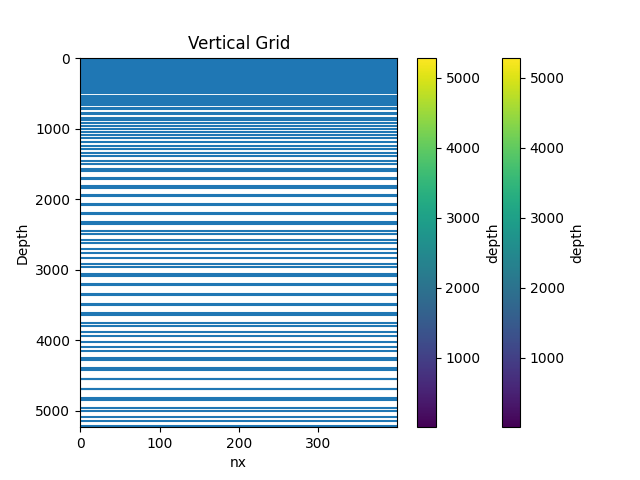

In [27]:
import matplotlib.pyplot as plt
plt.close()
# Create the plot
for depth in vgrid.z:
    plt.axhline(y=depth, linestyle='-')  # Horizontal lines

plt.ylim(max(vgrid.z) + 10, min(vgrid.z) - 10)  # Invert y-axis so deeper values go down
plt.ylabel("Depth")
plt.title("Vertical Grid")
plt.show()

# SECTION 3: Create the CESM case

After generating the MOM6 domain, the next step is to create a CESM case using CrocoDash. This process is straightforward and involves instantiating the CrocoDash Case object. The Case object requires the following inputs:

 - CESM Source Directory: A local path to a compatible CESM source copy.
 - Case Name: A unique name for the CESM case.
 - Input Directory: The directory where all necessary input files will be written.
 - MOM6 Domain Objects: The horizontal grid, topography, and vertical grid created in the previous section.
 - Project ID: (Optional) A project ID, if required by the machine.

## Step 2.1: Specify case name and directories:

Begin by specifying the case name and the necessary directory paths. Ensure the CESM root directory points to your own local copy of CESM. 
**Note that if the case is already created - in case you want to rerun this notebook - the `/run` directory must be removed for the case to be created anew.**
Below is an example setup:

In [28]:
from pathlib import Path

In [29]:
# CESM case (experiment) name
casename = "antarctica-tutorial"

# CESM source root (Update this path accordingly!!!)
cesmroot = "/glade/work/hmnguyen/CESM"

# Place where all your input files go
inputdir = Path.home() / "input" / casename

# CESM case directory
caseroot = Path.home() / "cases" / casename
print(cesmroot, inputdir, caseroot) # View your directory and change as you need!

/glade/work/hmnguyen/CESM /glade/u/home/hmnguyen/input/antarctica-tutorial /glade/u/home/hmnguyen/cases/antarctica-tutorial


## Step 2.2: Create the Case

To create the CESM case, instantiate the `Case` object as shown below. This will automatically set up the CESM case based on the provided inputs: The `cesmroot` argument specifies the path to your local CESM source directory.
The `caseroot` argument defines the directory where the case will be created. CrocoDash will handle all necessary namelist modifications and XML changes to align with the MOM6 domain objects generated earlier.

Remember to change/remove your project ID (with parameter `project`) and machine (with parameter `machine`, likely `derecho`) as needed.

In [30]:
from CrocoDash.case import Case
import os
os.environ["CIME_MACHINE"] = "ubuntu-latest"
case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'P93300012', # Switch this
    override = True,
    machine = "derecho", # And this
    #compset = "1850_DATM%JRA_SLND_CICE_MOM6_SROF_SGLC_SWAV", # Uncomment when Alper's PR is approved
)

ERROR:  cime_interface:DIN_LOC_ROOT doesn't exist: /glade/u/home/hmnguyen/cesm/inputdata
INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "antarctica-tutorial" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "antarctica2".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "antarctica2" with the following properties:
 nx: 400, ny: 400. ocean mesh: /glade/u/home/hmnguyen/input/antarctica-tutorial/ocnice/ESMF_mesh_antarctica2_b06b3a.nc.

Running the create_newcase tool with the following command:

/glade/work/hmnguyen/CESM/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_CICE_MOM6_SROF_SGLC_SWAV --res antarctica-tutorial --case /glade/u/home/hmnguyen/cases/antarctica-tutorial --machine derecho --run-unsupported --project P93300012 --non-local 

The create_newcase command was successful.

Navigating to the case directory:

cd /glade/u/home/hmnguyen/cases/antarctica-tutorial

Apply NTASK grid xml changes:

./xmlchange NTASKS_OCN=2

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/u/home/hmnguyen/cases/antarctica-tutorial.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.



# Section 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `CrocoDash` package, called `configure_forcings`, that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

## Step 3.1 Configure Initial Conditions and Forcings

In [31]:
from CrocoDash.case import Case
# Turn off tides for now - 30/06/2025
case.configure_forcings(
    date_range = ["2020-01-01 00:00:00", "2020-01-09 00:00:00"],
    #tidal_constituents = ['M2'],
    #tpxo_elevation_filepath = "/glade/u/home/hmnguyen/ncfile/h_tpxo9.v1.nc",
    #tpxo_velocity_filepath = "/glade/u/home/hmnguyen/ncfile/u_tpxo9.v1.nc",
    too_much_data = False,
    #regridding_method="patch" # tried nearest_d2s, nearest_s2d, bilinear
)

INFO:CrocoDash.raw_data_access.datasets.glorys:This data access method retuns a script at path /glade/derecho/scratch/hmnguyen/tmp/tmp80sctdeh/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.raw_data_access.datasets.glorys:This data access method retuns a script at path /glade/u/home/hmnguyen/input/antarctica-tutorial/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.raw_data_access.datasets.glorys:This data access method retuns a script at path /glade/u/home/hmnguyen/input/antarctica-tutorial/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.raw_data_access.datasets.glorys:This data access method retuns a script at path /glade/u/home/hmnguyen/input/antarctica-tutorial/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.raw_data_access.datasets.glorys:This data access method retuns a script at path /glade/u/home/hmnguyen/input/antarctica-tutorial/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.raw_data

## Step 3.2 Run `get_glorys_data.sh`

Follow the instructions printed by the `configure_forcings` method above to navigate to your `glorys` folder.
Once you're in your `/glorys` folder, run `chmod +x get_glorys_data.sh` to enable execution of the bash script. Also activate your conda environment with:
```bash
module load conda && conda activate CrocoDash ! or the name of the virtual environment you have installed with CrocoDash enabled
```
if you haven't done so. Finally, run `./get_glorys_data.sh`.

**Note**: You'll have to enter your login multiple times for `copernicus marine`. Do not escape the script until finished.


**TODO:** user copernicusmarine python API within CrocoDash, instead of directing users to run it via CLI. Also, on a derecho login node, both CLI and API fails to run due to the computational demand. We also need to address that.

##  Step 3.3: Process forcing data

In this final step, we call the `process_forcings` method of CrocoDash to cut out and interpolate the initial condition as well as all boundaries. CrocoDash also updates MOM6 runtime parameters and CESM xml variables accordingly.

In [32]:
case.process_forcings(
    process_velocity_tracers = True, 
    process_initial_condition = True, 
    process_tides = False, # No tides for now
    #bathymetry_path = "/glade/u/home/hmnguyen/jupyter/bathymetry.nc" 
)

INFO:regional_mom6.regridding:Getting t points..
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder


Setting up Initial Conditions
Regridding Velocities... 

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Getting u points..
INFO:regional_mom6.regridding:Getting v points..


Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... 

INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically


done setting up initial condition.
Processing south boundary velocity & tracers...

INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_001
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_001
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to u_segment_001
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in v_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:r

Done.
Processing north boundary velocity & tracers...

INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_002
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_002
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to u_segment_002
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in v_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to v_segment_002
INFO:regional_mom6.regridding:Adding perpendicular dimension to eta_s

Done.
Processing west boundary velocity & tracers...

INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_003
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_003
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to u_segment_003
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in v_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to v_segment_003
INFO:regional_mom6.regridding:Adding perpendicular dimension to eta_segment_003
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mo

Done.
Processing east boundary velocity & tracers...

INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_004
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to u_segment_004
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in v_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to v_segment_004
INFO:regional_mom6.regridding:Adding perpendicular dimension to eta_segment_004
INFO:regional_mom6.regridding:Generating encoding dictionary


Done.
Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  Z_INIT_FILE_PTEMP_VAR = temp
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_CONFIG = file
  VELOCITY_FILE = init_vel.nc

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = False
  OBC_COMPUTED_VORTICITY = True
  OBC_COMPUTED_STRAIN = True
  OBC_ZERO_BIHARMONIC = True
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_OUT = 3.0E+04
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_IN = 3000.0
  BRUSHCUTTER_MODE = True
  OBC_SEGMENT_001 = "J=0,I=0:N,FLATHER,ORLANSKI,NUDGED,ORLANSKI_TAN,NUDGED_TAN"
  OBC_SEGMENT_001_VELOCITY_NUDGING_TIMESCALES = 0.3, 360.0
  OBC_SEGMENT_001_DATA = "U=file:forcing_obc_segment_001.nc(u),V=file:forcing_obc_segment_001.nc(v),SSH=file:forcin

# Section 4: Set up CICE grids and extra MOM & CICE variables

## 4.1. Options in `user_nl_mom`
The variables below are set to the default of MOM6. Consider changing their values if needed.

In [34]:
mom_file_path = caseroot / "user_nl_mom"

mom_settings = {
    "USE_CFC_CAP": False,
    "READ_TIDEAMP": False,
    "MASKING_DEPTH": -9999.0,
}
# Optionally, if you have a H2 file, insert it above as well, e.g., "H2_FILE": "file/path/..."

with open(mom_file_path, "a") as f:
    f.write("\n")
    for key, value in mom_settings.items():
        f.write(f"{key}={value}\n")

## 4.2 Generate CICE grid

In [35]:
topo.write_cice_grid(Path.home() / "input" / casename / "cice_grid.nc")

## 4.3. Options in `user_nl_cice`

In [38]:
cice_grid_path = Path.home() / "input" / casename / "cice_grid.nc"
cice_file_path = caseroot / "user_nl_cice"

cice_settings = { # Again, change as needed!
    "ice_ic": "UNSET",
    "grid_file": cice_grid_path,
    "kmt_file": cice_grid_path,
    "grid_format": "nc",
    "ns_boundary_type": "open",
    "ew_boundary_type": "cyclic",
    "close_boundaries": ".false."
}

with open(cice_file_path, "a") as f:
    f.write("\n")
    for key, value in cice_settings.items():
        f.write(f"{key}={value}\n")

## Optional: Use restart files as initial condition for your run

In case you want to start the model with a restart file instead of using the generated initial condition, follow the below steps. Note that you have to have finished a run beforehand for the restart files to appear.
1. Locate your restart file - they are usually in your previous case's `/archive/rest/<year>` folder with a `.r` infix, e.g., `cice.test.cice.r.1994-01-01-00000.nc`.
   If you do not know your `/archive` folder location, run `./xmlquery DOUT_S_ROOT` in your (previous) case folder, which will return a path similar to `DOUT_S_ROOT: /glade/derecho/scratch/hmnguyen/archive/antarctica-tutorial`.

2. Use the `cp` command to copy the file to your current case `/run` directory, e.g., `cp cice.test.cice.r.1994-01-01-00000.nc <your_run_dir>`.
3. Open `user_nl_cice` in your case directory again and change the `ice_ic` variable from `"UNSET"` to your file name, e.g., `ice_ic=cice.test.cice.r.1994-01-01-00000.nc`

Your file will now be used automatically as the ice initial condition for your next run. Note that `.h` and `.h1` files (i.e. history files) currently **cannot be used** as initial conditions for CICE.

# Section 5: Build and run the case

After completing the previous steps, you are ready to build and run your CESM case. Begin by navigating to the case root directory specified during the case creation. Before proceeding, review the `user_nl_mom` file located in the case directory. This file contains MOM6 parameter settings that were automatically generated by CrocoDash. Carefully examine these parameters and make any necessary adjustments to fine-tune the model for your specific requirements. While CrocoDash aims to provide a solid starting point, further tuning and adjustments are typically necessary to improve the model for your use case.

Once you have reviewed and modified the parameters as needed, you can build and execute the case using the following commands: 
```
./case.build
./case.submit
```

### Optional: Write full grid

The function below will output the full MOM6 grid in case you need it!

In [37]:
import xarray as xr
from CrocoDash.grid import Grid

# List of explicitly defined grid metric attributes
varnames = [
    "tlon", "tlat", "ulon", "ulat", "vlon", "vlat", "qlon", "qlat",
    "dxt", "dyt", "dxCv", "dyCu", "dxCu", "dyCv", "angle", "tarea"
]

data_vars = {name: getattr(grid, name) for name in varnames}

# Create Dataset
ds = xr.Dataset(data_vars)
ds.attrs["name"] = getattr(grid, "_name", "unnamed_grid")

# Write to NetCDF
ds.to_netcdf("antarctica_fullvar_grid.nc") # Change as needed!

In [35]:
# Check your variables!
for name in varnames:
    var = getattr(grid, name)
    print(f"{name}: shape={var.shape}, dims={getattr(var, 'dims', 'unknown')}")

tlon: shape=(100, 100), dims=('ny', 'nx')
tlat: shape=(100, 100), dims=('ny', 'nx')
ulon: shape=(100, 101), dims=('ny', 'nxp')
ulat: shape=(100, 101), dims=('ny', 'nxp')
vlon: shape=(101, 100), dims=('nyp', 'nx')
vlat: shape=(101, 100), dims=('nyp', 'nx')
qlon: shape=(101, 101), dims=('nyp', 'nxp')
qlat: shape=(101, 101), dims=('nyp', 'nxp')
dxt: shape=(100, 100), dims=('ny', 'nx')
dyt: shape=(100, 100), dims=('ny', 'nx')
dxCv: shape=(100, 100), dims=('ny', 'nx')
dyCu: shape=(100, 100), dims=('ny', 'nx')
dxCu: shape=(100, 100), dims=('ny', 'nx')
dyCv: shape=(100, 100), dims=('ny', 'nx')
angle: shape=(100, 100), dims=('ny', 'nx')
angle_q: shape=(101, 101), dims=('ny', 'nx')
tarea: shape=(100, 100), dims=('ny', 'nx')
